### Using LC CRF

In [1]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


### 1- Importing libraries


In [30]:
!pip install Sastrawi

In [31]:
!pip install python-crfsuite

In [32]:
!pip install wordcloud

In [33]:
#Load all the needed libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import json
from pprint import pprint
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
import pycrfsuite

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/ndsc-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
plt.style.use('seaborn-ticks')

In [35]:
#from google.colab import drive
#drive.mount('/content/drive')

## 2- Loading Train/test data

In [36]:
#path = '/content/drive/My Drive/GitHub/nsdc_beginner/Data'

path = './Data'
dftrain = pd.read_csv(os.path.join(path, 'train.csv'))
dftest = pd.read_csv(os.path.join(path, 'test.csv'))


In [37]:
with open(os.path.join(path,'categories.json')) as f:
    categories = json.load(f)

pprint(categories)

{'Beauty': {'BB & CC Cream': 5,
            'Blush On': 2,
            'Bronzer': 11,
            'Concealer': 7,
            'Contour': 6,
            'Face Palette': 0,
            'Foundation': 1,
            'Highlighter': 8,
            'Lip Gloss': 14,
            'Lip Liner': 15,
            'Lip Tint': 13,
            'Lipstick': 12,
            'Other Face Cosmetics': 4,
            'Other Lip Cosmetics': 16,
            'Powder': 3,
            'Primer': 9,
            'Setting Spray': 10},
 'Fashion': {'A Line Dress': 21,
             'Big Size Dress': 24,
             'Big Size Top': 30,
             'Blouse': 26,
             'Bodycon Dress': 22,
             'Casual Dress': 18,
             'Crop Top': 29,
             'Maxi Dress': 20,
             'Others': 17,
             'Party Dress': 19,
             'Shirt': 27,
             'Tanktop': 28,
             'Tshirt': 25,
             'Wedding Dress': 23},
 'Mobile': {'Advan': 45,
            'Alcatel': 55,
            

Swap the key and value

In [38]:
F_cat_dict = dict((v,k.strip()) for k,v in categories['Fashion'].items())
F_cat_dict

{23: 'Wedding Dress',
 27: 'Shirt',
 18: 'Casual Dress',
 20: 'Maxi Dress',
 24: 'Big Size Dress',
 22: 'Bodycon Dress',
 19: 'Party Dress',
 26: 'Blouse',
 25: 'Tshirt',
 29: 'Crop Top',
 28: 'Tanktop',
 17: 'Others',
 21: 'A Line Dress',
 30: 'Big Size Top'}

## 3- Feature Engineering

### 3.1 Divide the training data into Big categories containers (Beauty/Fashion/Mobile)

In [39]:
# 1. add a new col that contins the big category (beauty, fashion, mobile)

newCol = dftrain.image_path.apply(lambda x : x.split('_')[0])
dftrain['mainCat'] = newCol
# dftrain.head()

Check for unique values

In [40]:
set(dftrain['mainCat'])

{'beauty', 'fashion', 'mobile'}

### 3.2 Display the total number of samples under each category

In [41]:
Beautydf= dftrain[dftrain['mainCat'] == 'beauty']
Fashiondf= dftrain[dftrain['mainCat'] == 'fashion']
Mobiledf= dftrain[dftrain['mainCat'] == 'mobile']

### 3.3 Randomize the train-dataset

To avoid bias in the training dataset, it is a good practice

In [42]:
# randomize datasets

Beautydf = Beautydf.reindex(np.random.permutation(Beautydf.index))
Fashiondf = Fashiondf.reindex(np.random.permutation(Fashiondf.index))
Mobiledf = Mobiledf.reindex(np.random.permutation(Mobiledf.index))

### 3.4 Remove any number with more than 3 digits in the dataset

For example : `02854323232` which could be an id or something


In [43]:
# Remove any number in the dataset with more than or equal to 3 digits. 

Beautydf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Fashiondf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Mobiledf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)

580357                                    iphone 4 32gb gsm
589884    ao slim silicone matte soft samsung j7 pro j5 ...
636381    promo spesial asus zenfone max pro 3g 32gb wa ...
540972                           oppo f7 128gb diamon black
527302                                     iphone 6s  gb bm
515918    advan hammer hape senter camera 5 mp duos sim ...
666208    clear view standing cover samsung galaxy s8 or...
631205    promo beli 2 gratis 1 iphone x 256gb asli orig...
635596    stok terbatas samsung galaxy note9 128gb midni...
559384                                             oppo a39
522029    promo gajian seru 26 28 seb ready stock terbar...
546678    promo nokia  dual sim black garansi resmi term...
613828          resmi tam redmi 4a prime 32gb grey new bnib
621560                                         iphone 6  gb
529546    beli 2 dapat 3 dell vostro 14  notebook hitam ...
664474                                   iphone x 64gb gray
515821     big ramadhan sale beli limite

In [44]:
### 3.5 Doing further analysis on the Fashion category

In [45]:
Fashiondf['Category'].value_counts()

18    56598
25    33922
26    33845
20    19978
27    16199
22    15225
19    13493
21    10483
28     6493
24     4251
29     3338
17     2765
23     1671
30     1441
Name: Category, dtype: int64

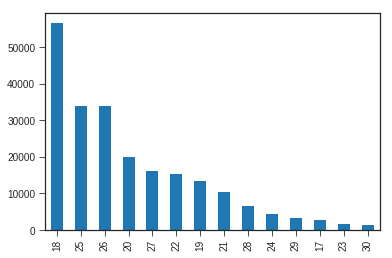

In [46]:
Fashiondf['Category'].value_counts().plot(kind='bar');

### 4.0 Starting with LC CRF

In [47]:
F_18_df = Fashiondf[Fashiondf['Category']==18]
F_18_data = tuple(zip(F_18_df.title, F_18_df.Category))

In [48]:
F_18_df.head()

,itemid,title,Category,image_path,mainCat
397722,1685070620,dress sexy model deep v neck warna polos bahan...,18,fashion_image/c2b23fa478645dc3ed67ac124c741203,fashion
386465,1483509789,dress fit and flare motif print bunga bahan la...,18,fashion_image/50ff780cb5ded54b08cd1593d80a1ba3,fashion
322351,1635374027,lapangan gas panjang selutut rok sweater jahit...,18,fashion_image/e2e098f687826ac533f1d36492170b95,fashion
292496,1600415573,gogo dress mini lengan panjang model off shoul...,18,fashion_image/bd4c42e87c2194d75801ad07f69eb39c,fashion
304564,416590369,hcl dress wanita eliva brukat minidress pesta,18,fashion_image/204128113025fda29a34186deccc1a02,fashion


In [49]:
F_18_data[0:5]

(('dress sexy model deep v neck warna polos bahan lace untuk wanita', 18),
 ('dress fit and flare motif print bunga bahan lace warna putih susu', 18),
 ('lapangan gas panjang selutut rok sweater jahitan renda pinggang rajut gaun untuk',
  18),
 ('gogo dress mini lengan panjang model off shoulder longgar dengan kancing untuk wanita',
  18),
 ('hcl dress wanita eliva brukat minidress pesta', 18))

#### 4.1 Using FLAIR

In [50]:
!pip install flair

In [51]:
!pip install apex

  Using cached https://files.pythonhosted.org/packages/73/bd/714b3fbfb3392d6b4e658638d9b74f77ce1072725209c08a6becd90836a7/cryptacular-1.4.1.tar.gz
  Complete output from command /home/ndsc-user/anaconda3/envs/tf_gpu/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-tagu_yh4/cryptacular/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-t_lqsx7_ --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/cryptacular
  copying cryptacular/__init__.py -> build/lib.linux-x86_64-3.6/cryptacular
  creating build/lib.linux-x86_64-3.6/cryptacular/crypt
  copying cryptacular/crypt/__init__.py -> build/lib.linux-x86_64-3.6/cryptacular/crypt
  copying cryptacular/crypt/test_crypt.py -> build/lib.linux-x86_64-3.6/cryptacular/crypt
  creating build/lib.

Failed to build cryptacular
  Running setup.py install for cryptacular ... error
    Complete output from command /home/ndsc-user/anaconda3/envs/tf_gpu/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-tagu_yh4/cryptacular/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-record-7layo4lr/install-record.txt --single-version-externally-managed --compile:
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.6
    creating build/lib.linux-x86_64-3.6/cryptacular
    copying cryptacular/__init__.py -> build/lib.linux-x86_64-3.6/cryptacular
    creating build/lib.linux-x86_64-3.6/cryptacular/crypt
    copying cryptacular/crypt/__init__.py -> build/lib.linux-x86_64-3.6/cryptacular/crypt
    copying cryptacular/crypt/test_crypt.py -> build/lib.linux-x86_64-3.6/cryptacular/crypt
    creating build/

Using stacked embeddings

Running this on our data

In [52]:
#flair_path = '/content/drive/My Drive/GitHub/nsdc_beginner/Flair'
flair_path = './Flair'


train_path = os.path.join(flair_path, "train.csv")
test_path = os.path.join(flair_path, "test.csv")
dev_path = os.path.join(flair_path, "dev.csv")

data = Fashiondf[['Category', 'title']].rename(columns={"Category":"label", "title":"text"})



In [53]:
data.head()

,label,text
462261,26,loose programmer php world sweater kaos lengan...
397722,18,dress sexy model deep v neck warna polos bahan...
386465,18,dress fit and flare motif print bunga bahan la...
322351,18,lapangan gas panjang selutut rok sweater jahit...
292496,18,gogo dress mini lengan panjang model off shoul...


In [54]:
data['label'] = '__label__' + data['label'].astype(str)

data.iloc[0:int(len(data)*0.8)].to_csv(train_path, sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv(test_path, sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv(dev_path, sep='\t', index = False, header = False);

#### 4.2 Training custom text

Get the corpus

In [58]:
!pip install google-compute-engine

In [59]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, \
    DocumentRNNEmbeddings,CharLMEmbeddings,BertEmbeddings, ELMoEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

sample_size=1.0

In [ ]:
corpus = NLPTaskDataFetcher.load_classification_corpus(Path(flair_path), 
                                                       test_file='test.csv', 
                                                       dev_file='dev.csv', 
                                                       train_file='train.csv')#.downsample(sample_size)

#word_embeddings = [WordEmbeddings('glove'), 
#                   FlairEmbeddings('news-forward'), 
#                   FlairEmbeddings('news-backward')]

#word_embeddings = [WordEmbeddings('en')]

word_embeddings = [WordEmbeddings('en'),
                   FlairEmbeddings('multi-forward'),
                   FlairEmbeddings('multi-backward')]

2019-03-18 12:31:33,900 Reading data from Flair
2019-03-18 12:31:33,901 Train: Flair/train.csv
2019-03-18 12:31:33,902 Dev: Flair/dev.csv
2019-03-18 12:31:33,903 Test: Flair/test.csv


In [ ]:
document_embeddings = DocumentRNNEmbeddings(word_embeddings, 
                                            hidden_size=64, 
                                             reproject_words=True, 
                                             reproject_words_dimension=256,
                                           #mini_batch_size=128,
                                           #learning_rate=0.15,
                                           rnn_layers=2,
                                           dropout=0.2262)

Initialize trainer

In [ ]:
#model_path = '/content/drive/My Drive/GitHub/nsdc_beginner/Model'
model_path = './Model20190318-2031'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [ ]:
classifier = TextClassifier(document_embeddings, 
                            label_dictionary=corpus.make_label_dictionary(), 
                            multi_label=False)

trainer = ModelTrainer(classifier, corpus)

trainer.train(model_path, 
              learning_rate =0.15,
              mini_batch_size=128,
              anneal_factor=0.5,
              max_epochs=30, 
              patience=1,
             checkpoint=True)

Plot the training

In [ ]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves(os.path.join(model_path,'loss.tsv'))
plotter.plot_weights(os.path.join(model_path, 'weights.txt'))

Training progress - with glove and multi flair backward and forward
<img src="./Model20190318-1859/training.png"/>

Making predictions

In [ ]:
from flair.data import TaggedCorpus, Sentence, Token

def predictSentences(sentences, classifier, print_on_pct=0.01):
    print ("Starting progress on prediction work")
    # get the total number of sentences to be processed
    to_proc = len(sentences)
    y_preds = []
    
    processed = 0
    count = 0
    print_count = to_proc*print_on_pct

    for sentence in sentences:
        sentence = Sentence(sentence)

        # predict tags and print
        classifier.predict(sentence)
    
        y_preds.append(int(sentence.labels[0].value))
        processed += 1
        count += 1
        if (count >= print_count):
            count = 0

            # print the current status
            pct = round((float(processed)/float(to_proc))*100, 3)
            print ("{} {}% finished".format(datetime.datetime.now(), pct))
            
    return y_preds

        
classifier = TextClassifier.load_from_file(os.path.join(model_path,'final-model.pt'))    
# create example sentence
sentences = ['zaful long dress vintage wanita v neck lengan panjang hollow bahan sifon motif print bunga',
            'terlaris best seller basic shirt square motif bl4834 new',
            "dress bodycon wanita model lengan panjang bahan velvet untuk musim dingin prom cocktail"]
print(predictSentences(sentences, classifier))

#### 4.3 Hyperopt it

In [ ]:
!pip install allennlp

In [ ]:
from hyperopt import hp
from flair.hyperparameter.param_selection import SearchSpace, Parameter

# define your search space
search_space = SearchSpace()
search_space.add(Parameter.EMBEDDINGS, hp.choice, options=[
    [ WordEmbeddings('en') ], 
    [ CharLMEmbeddings('news-forward'), CharLMEmbeddings('news-backward') ],
    [ WordEmbeddings('glove'), FlairEmbeddings('news-forward'),
     FlairEmbeddings('news-backward')],
    [BertEmbeddings('bert-base-multilingual-cased')],
    [ELMoEmbeddings('original')],
    [FlairEmbeddings('multi-forward'),FlairEmbeddings('multi-backward'),
     BertEmbeddings('bert-base-multilingual-cased')]
])
search_space.add(Parameter.HIDDEN_SIZE, hp.choice, options=[64, 128, 256, 512])
search_space.add(Parameter.RNN_LAYERS, hp.choice, options=[1, 2])
search_space.add(Parameter.DROPOUT, hp.uniform, low=0.0, high=0.5)
search_space.add(Parameter.LEARNING_RATE, hp.choice, options=[0.05, 0.1, 0.15, 0.2])
search_space.add(Parameter.MINI_BATCH_SIZE, hp.choice, options=[8, 16, 32, 64, 128])

Create the actual parameter selector

In [ ]:
from flair.hyperparameter.param_selection import TextClassifierParamSelector,\
    OptimizationValue

# create the parameter selector
param_selector = TextClassifierParamSelector(
    corpus, 
    False, 
    model_path, 
    'lstm',
    max_epochs=50, 
    training_runs=3,
    optimization_value=OptimizationValue.DEV_SCORE
)

# start the optimization
param_selector.optimize(search_space, max_evals=100)

#### 4.3 Finding the best learning rate

In [ ]:
# 7. find learning rate
learning_rate_tsv = trainer.find_learning_rate(model_path,                                                    'learning_rate.tsv')

# 8. plot the learning rate finder curve
plotter = Plotter()
plotter.plot_learning_rate(learning_rate_tsv)

#### 4.3 Manually validate the accuracy

In [ ]:
valid_data = Fashiondf.sample(frac=0.1)

In [ ]:
valid_data.shape

In [ ]:
y_true = list(valid_data.Category)

In [ ]:
type(y_true)

In [ ]:
list(valid_data[0:10].title)

In [ ]:
y_pred = predictSentences(list(valid_data.title), classifier)

In [ ]:
y_pred[0:10]

In [ ]:
y_true[0:10]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

## 5- Modelling

1. Divide the test dataset into 3 Categories
2. Remove numbers more than 3 Digits from the test dataset.
3. Train + Predict.


### 5.1 Divide the test dataset into 3 Categories

In [ ]:
#add category col
newTestCol = dftest.image_path.apply(lambda x: x.split('_')[0])
dftest['newCat'] = newTestCol

In [ ]:
dftest.tail()

In [ ]:
MobileTest = dftest[dftest['newCat'] == 'mobile']
BeautyTest = dftest[dftest['newCat'] == 'beauty']
FashionTest = dftest[dftest['newCat'] == 'fashion']

fig, axt = plt.subplots(1,1)
axt.bar(['beauty', 'fashion', 'mobile'], [len(BeautyTest), len(FashionTest), len(MobileTest)], width=0.5)


### 5.3 Prediction Dataset

In [ ]:
B_X_test = BeautyTest.title
F_X_test = FashionTest.title
M_X_test = MobileTest.title

### 5.4 Prediction Function

In [ ]:
def modelPredict(X_train, y_train, X_test, vect, 
                 clf=SGDClassifier(random_state=42,max_iter=5000, 
                                            tol=1e-3,loss='hinge')):
    ''' Train a classifier using CV'''
    #clf = SGDClassifier(random_state=random_state)
    
    X_train_dtm,X_test_dtm = tokenize_data(vect, X_train, X_test)
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)
    return y_pred

In [ ]:
B_y_pred = modelPredict(B_X_train, B_y_train, B_X_test, Bs_vect, clf=ovr_clf)

In [ ]:
F_y_pred = modelPredict(F_X_train, F_y_train, F_X_test, Fs_vect, clf=ovr_clf)

In [ ]:
M_y_pred = modelPredict(M_X_train, M_y_train, M_X_test, Ms_vect, clf=ovr_clf)

### 5.5 Run Prediction

In [ ]:
BeautyTest['Category'] = B_y_pred
FashionTest['Category'] = F_y_pred
MobileTest['Category'] = M_y_pred


## 6- Result

In [ ]:
resDf = BeautyTest.append(FashionTest).append(MobileTest)


In [ ]:
FinalResult = pd.concat([resDf['itemid'], resDf['Category']], axis=1, 
                        keys=['itemid', 'Category'])
FinalResult.to_csv(path + '{}_NDSC_Res.csv'.format(datetime.datetime.today().strftime('%Y%m%d')
                                                  ), index=False)